### Setup

In [ ]:
fig <- function(w,h){
    options(repr.plot.width = w, repr.plot.height = h)
}

library(dplyr)
library(Seurat)
library(glue)
library(future)
library(ggrepel)
library(ggh4x)

reserve <- 1
ncores <- parallel::detectCores()-reserve
plan(strategy = "multicore", workers = ncores)
options(future.globals.maxSize = 400*1024^3)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: ggplot2



In [ ]:
stylize <- function(p, rotate_x_45 = T, no.legend = F){

    require(ggpubr)
    
    p <- p + theme_light() + 
        labs_pubr() + 
        theme(strip.placement = 'outside', 
              panel.background = element_rect(fill = 'transparent', color = 'black'), 
              strip.text = element_text(color = 'black'), 
              strip.background = element_rect(fill = 'transparent', color = 'black'))
    if(rotate_x_45){
        p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))
    }
    if(no.legend){
        p <- p + theme(legend.position = 'none')
    }
    return(p)
}

my.barplot <- function(metadata, var=NULL, fill_var=NULL, column_var=NULL, row_var=NULL, palette = NULL,
                       scales = 'free', space = 'fixed', flip=F, switch = 'y'){

    require(ggplot2)
    require(ggh4x)

    p <- ggplot(metadata, 
                aes_string(
                    y=var,
                    fill=fill_var)) + 
        geom_bar() 

    if (!is.null(fill_var) & !is.null(palette)){
        p <- p + scale_fill_manual(values = palette)
    }

    if (flip){
        p <- p + coord_flip()
    }
    if (!(is.null(column_var) & is.null(row_var))){
        
        if (!is.null(row_var)){
            p$data$row_var <- p$data[,row_var]
            row_var <- vars(row_var)
        } else {
            row_var <- NULL
        }
        if (!is.null(column_var)){
            p$data$column_var <- p$data[,column_var]
            column_var <- vars(column_var)
        } else {
            column_var <- NULL   
        }
        p <- p + facet_nested(rows = row_var, cols = column_var, scales = scales, space = space, switch = switch)
    }

    return(p)
    
}

In [ ]:
markers_dir <- 'markers_pairwise/RG/'
plot_dir <- paste0(markers_dir, 'plots.v4/')
markers_subdir <- paste0(markers_dir, 'pairwise/')
dir.create(markers_subdir, recursive = T, showWarnings = F)
dir.create(plot_dir, recursive = T, showWarnings = F)

tf_list_path <- '/users/genomics/xoel/codebases/cortical_disorders2/raw/HumanTFs/DatabaseExtract_v_1.01.csv'

int.vars <- c('library','individual','family','family.grouping','ASD.diagnosis','stage','cell.cluster','cell.type')

In [4]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3335656,178.2,5453367,291.3,5453367,291.3
Vcells,5827892,44.5,12255594,93.6,9427120,72.0


### Load data

In [ ]:
tf.list <- data.table::fread(tf_list_path, data.table=F) %>% 
    mutate(V1 = NULL) %>%
    subset(grepl('Yes', `Is TF?`)) %>% 
    select(`HGNC symbol`) %>% 
    unlist(recursive = T) %>%
    gsub(pattern = ' ', replacement = '', fixed = T) %>% 
    unname %>% unique 

In [ ]:
# File containing supplementary study data (DEGs from previous study)
study_data_file <- 'supp_table.9.per_donor_DEGs.xlsx'
# genes of interest
study.data <- openxlsx::read.xlsx(study_data_file, skipEmptyRows = T, startRow = 4)

In [ ]:
# Input Seurat object file
seurat_object_file <- 'input/SeuratObject_Jourdon.et.al.2023_TD0_only.rds'
obj <- readRDS(seurat_object_file)
obj

An object of class Seurat 
19035 features across 231887 samples within 1 assay 
Active assay: RNA (19035 features, 0 variable features)
 1 layer present: counts

Loading required package: ggpubr

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


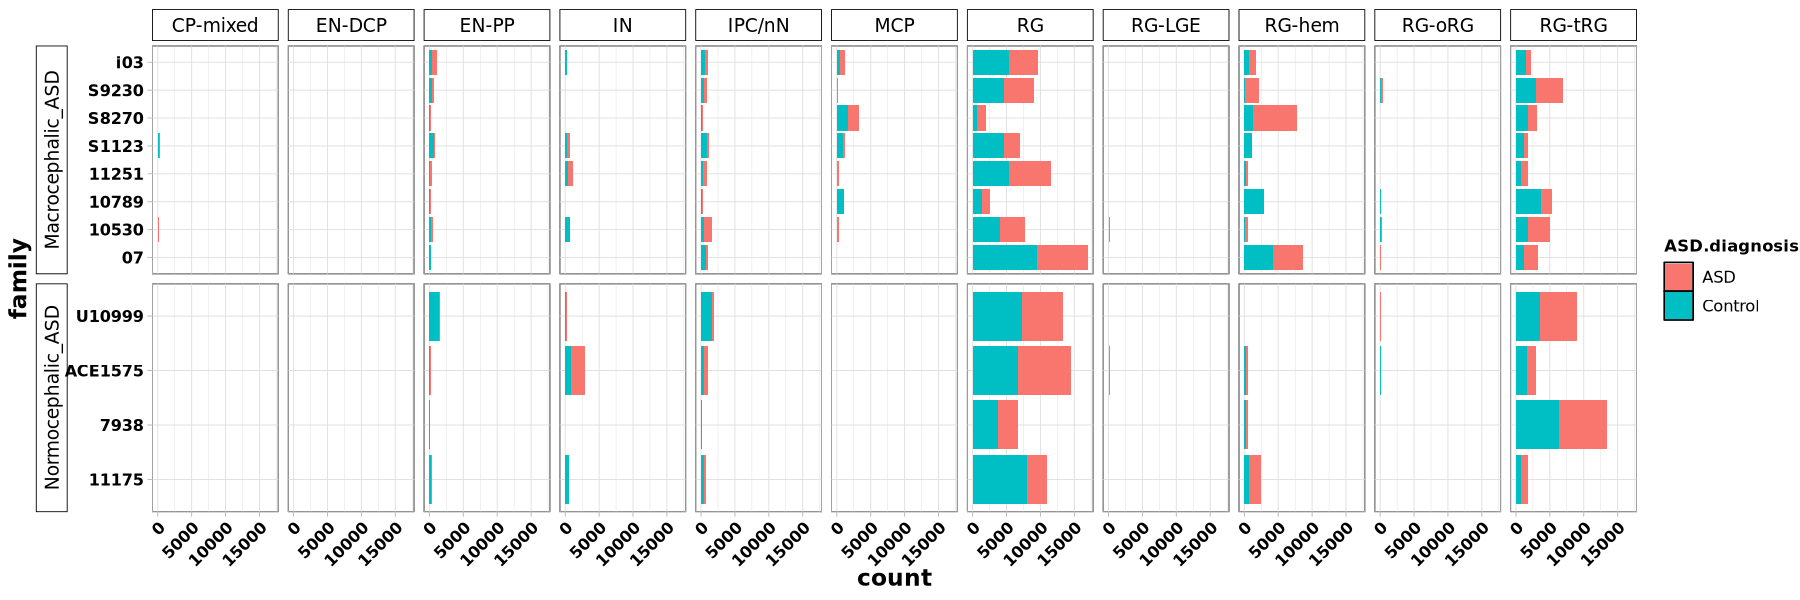

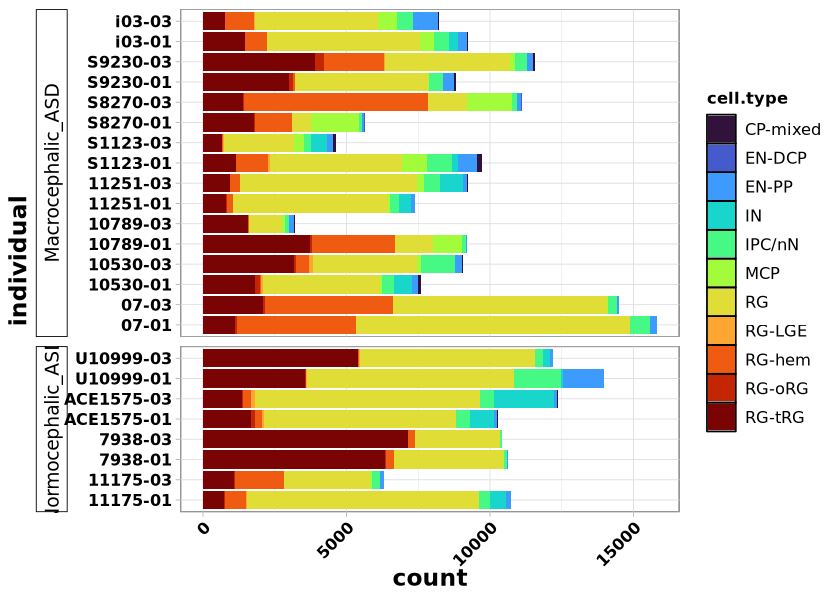

In [8]:
fig(15,5)
p1 <- my.barplot(obj@meta.data, var = 'family', fill_var='ASD.diagnosis', column_var = 'cell.type', row_var = 'family.grouping', flip=F, scales='free_y') %>% stylize()
p1

fig(7,5)
p2 <- my.barplot(obj@meta.data, var = 'individual', fill_var='cell.type', row_var = 'family.grouping', flip=F, scales='free_y', space='free') + scale_fill_viridis_d(option='turbo')
p2 %>% stylize()

#### Subset and preprocess

In [ ]:
rg.obj <- CreateSeuratObject(counts = subset(obj, cell.type == 'RG')[['RNA']]$counts, assay = 'RNA', min.cells = 0, min.features = 0, meta.data = subset(obj, cell.type == 'RG')@meta.data)
rg.obj

An object of class Seurat 
19035 features across 112008 samples within 1 assay 
Active assay: RNA (19035 features, 0 variable features)
 1 layer present: counts

In [ ]:
rg.obj <- SCTransform(rg.obj, verbose = TRUE, return.only.var.genes = FALSE)
rg.obj

Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.



In [ ]:
# These are now standard steps in the Seurat workflow for visualization and clustering
rg.obj <- RunPCA(rg.obj, verbose = T)
rg.obj <- RunUMAP(rg.obj, dims = 1:30, verbose = T)

rg.obj <- FindNeighbors(rg.obj, dims = 1:30, verbose = T)
rg.obj <- FindClusters(rg.obj, verbose = T)

In [ ]:
fig(20,20)
DimPlot(rg.obj, label = TRUE, raster = F, group.by = int.vars)

In [ ]:
rg.obj

### Pair-wise DEG in RG

#### Table of comparisons per donor

In [ ]:
all.donors <- unique(rg.obj$individual)
asd.donors <- unique(subset(rg.obj@meta.data, ASD.diagnosis == 'ASD')$individual)
ctr.donors <- unique(subset(rg.obj@meta.data, ASD.diagnosis != 'ASD')$individual)

In [ ]:
# Define all possible comparisons
comps <- expand.grid(all.donors, all.donors)
# Sort each pair to detect duplicates
comps <- apply(comps, 1, sort) %>% t() %>% as.data.frame
# Rename
colnames(comps) <- c('D1', 'D2')
# Label each comparison
comps$label <- apply(comps, 1, paste, collapse = '___')
# Sort them
comps <- comps %>% arrange(label)
# Remove same to same comparisons
comps <- comps[comps$D1 !=comps$D2,]
# Remove duplicated comparisons
comps <- comps[!duplicated(comps$label),]
# Define the paths
comps$path <- paste0(getwd(), '/', markers_subdir, comps$label, '.csv')
# define a compindex
comps$idx <- 1:nrow(comps)
rownames(comps) <- comps$idx

head(comps)


# Add metadata
add.meta <- rg.obj@meta.data[,c('library','individual','family','family.grouping','ASD.diagnosis')] %>% unique()
comps <- comps %>% 
    merge(y = add.meta, by.x = 'D1', by.y = 'individual', all.x = T, all.y = F) %>% 
    merge(y = add.meta, by.x = 'D2', by.y = 'individual', all.x = T, all.y = F, suffixes = c('.D1', '.D2')) %>%
    select(D1, D2, everything()) %>% arrange(idx)

# Assign group masks
comps$group.Fsame <- comps$family.D1 == comps$family.D2
comps$group.Fdiff <- comps$family.D1 != comps$family.D2
comps$group.F <- ifelse(comps$group.Fsame, 'Same family', 'Different family')

comps$group.AvA <- (comps$ASD.diagnosis.D1 == 'ASD') & (comps$ASD.diagnosis.D2 == 'ASD') 
comps$group.CvC <- (comps$ASD.diagnosis.D1 != 'ASD') & (comps$ASD.diagnosis.D2 != 'ASD') 
comps$group.AvC <- (comps$ASD.diagnosis.D1  != comps$ASD.diagnosis.D2)
comps$group.AvCs <- comps$group.AvC & comps$group.Fsame
comps$group.AvCd <- comps$group.AvC & comps$group.Fdiff

comps$group.AC <- ifelse(comps$group.AvA, 'ASD vs ASD', 
                         ifelse(comps$group.CvC, 'Ctrl vs Ctrl', 
                                ifelse(comps$group.AvCs, 'ASD vs Ctrl (same family)', 'ASD vs Ctrl (diff family)')))

                         
comps$group.MvM <- (comps$family.grouping.D1 == 'Macrocephalic_ASD') & (comps$family.grouping.D2 == 'Macrocephalic_ASD') 
comps$group.NvN <- (comps$family.grouping.D1 != 'Macrocephalic_ASD') & (comps$family.grouping.D2 != 'Macrocephalic_ASD') 
comps$group.MvN <- (comps$family.grouping.D1  != comps$family.grouping.D2)
comps$group.MvNs <- comps$group.MvN & comps$group.Fsame
comps$group.MvNd <- comps$group.MvN & comps$group.Fdiff

comps$group.MN <- ifelse(comps$group.MvM, 'Macro vs Macro', 
                         ifelse(comps$group.NvN, 'Normo vs Normo', 
                                ifelse(comps$group.MvNs, 'Macro vs Normo (same family)', 'Macro vs Normo (diff family)')))
               

head(comps)

# Output file for the annotated pairwise comparisons table
comps_file <- glue('{markers_dir}/pairwise_comparisons_annotated.csv')
write.csv(comps, comps_file)

#### Comparisons per donor

In [ ]:
group_var <- 'individual'
# Output file for combined pairwise marker results
markers.results.file <- paste0(markers_dir, 'all.pairwise_results.csv')

if (!file.exists(markers.results.file)){
    markers.list <- apply(comps, MARGIN = 1, 
                          FUN = function(comp){
        
        print(paste0(comp['idx'], '/', max(comps$idx)))
        if (file.exists(comp['path'])){
            
            # load results
            message(paste('Loading results of', comp['label']))
            markers <- data.table::fread(comp['path'], data.table=F, nThread = parallel::detectCores()-reserve) %>% mutate(V1=NULL)
        
        } else {
    
            # set timer
            t0 <- Sys.time()
            message(paste('Started DEGs of', comp['label'], 'at:', t0))
            
            # find DEGs
            markers <- FindMarkers(
                rg.obj, features = rownames(rg.obj), verbose = T, 
                group.by = group_var, `ident.1` = comp['D1'], `ident.2` = comp['D2'])
            
            # set timer
            tf <- Sys.time()
            message(paste('> Took:', tf-t0))
            
    
            # Annotate results
            markers['Gene'] <- rownames(markers)
            markers['D1'] <- comp['D1']
            markers['D2'] <- comp['D2']
            markers$cell.type <- 'RG'
            
            # Save results
            data.table::fwrite(x = markers, comp['path'], row.names = T, nThread = parallel::detectCores()-reserve)       
        }
        
        return(markers)
    })

    # Concatenate results
    markers.all <- do.call(markers.list, what = 'rbind')
    # Save all results
    data.table::fwrite(x = markers.all, markers.results.file,  row.names = T, nThread = parallel::detectCores()-reserve)
}

## Results

In [ ]:
gss.names <- c(
    'jourdon_all', 
    'jourdon_tfs',
    'jourdon_degs',
    'jourdon_de_tfs',
    'CT_RG early.Donor_all.Bias_all.TF_all', 
    'CT_RG early.Donor_all.Bias_all.TF_TRUE'
)
gss.labels <- c('All genes', 'All TFs', 'All DEGs', 'All DE TFs', 'D8 DEGs', 'D8 DE TFs')
gss.dataset <- c('Jourdon', 'Jourdon', 'DE Jourdon', 'DE Jourdon', 'D8', 'D8')
gss.class <- c('All', 'TFs', 'All', 'TFs', 'All', 'TFs')
gss.pal <- setNames(viridisLite::turbo(length(gss.labels)), nm = gss.labels)

dataset.levels <- c('Jourdon', 'DE Jourdon', 'D8')
class.levels <- c('All', 'TFs')

group.names <- c('group.AvA', 'group.AvCs', 'group.AvCd', 'group.CvC')
group.labels <- c('ASD vs ASD', 'ASD vs Ctrl\n(same family)', 'ASD vs Ctrl\n(diff family)', 'Ctrl vs Ctrl')
group.levels <- c('ASD vs ASD', 'Ctrl vs Ctrl', 'ASD vs Ctrl\n(same family)', 'ASD vs Ctrl\n(diff family)')
group.pal <- setNames(c('red', 'purple', 'violet', 'cyan'), nm = group.labels)

#### Markers results

In [12]:
logfc.thres <- 1

In [ ]:
# Results
# Load combined pairwise marker results (using variable defined in Cell 23)
markers.all <- data.table::fread(markers.results.file, data.table=F, nThread = parallel::detectCores()-reserve) %>% mutate(V1 = NULL) 
markers.all$signif <- (markers.all$p_val_adj <= 0.05) & (abs(markers.all$avg_log2FC) >= logfc.thres)
markers.all$is_tf <- markers.all$Gene %in% tf.list
markers.all$mvalue <- -log10(markers.all$p_val_adj)
markers.all$mvalue_fin <- max(subset(markers.all, is.finite(mvalue))$mvalue)

# Load annotated pairwise comparisons table (using variable defined in Cell 21)
comps <- data.table::fread(comps_file, data.table=F, nThread = parallel::detectCores()-reserve) %>% mutate(V1 = NULL) 

In [14]:
gois.lists <- list('jourdon_all' = unique(markers.all$Gene),
                   'jourdon_degs' = unique(subset(markers.all, signif)$Gene),
                   'jourdon_tfs' = unique(subset(markers.all, is_tf)$Gene),
                   'jourdon_de_tfs' = unique(subset(markers.all, signif & is_tf)$Gene))

cts <- c('all', unique(study.data$Cell.type))
donors <- c('all', unique(study.data$Donor))
biases <- c('all', unique(study.data$Up.in.ASD.or.control))
tfs <- c('all', unique(study.data$`Is.TF?`))

for (ct in cts){

    ct.data <- study.data
    if (ct != 'all'){
        ct.data <- subset(ct.data, Cell.type == ct)
    }
    if(nrow(ct.data) == 0){
        next
    }

    for (donor in donors){

        donor.data <- ct.data
        if (donor != 'all'){
            donor.data <- subset(donor.data, Donor == donor)
        }
        if(nrow(donor.data) == 0){
            next
        }

        for (bias in biases){

            bias.data <- donor.data
            if (bias != 'all'){
                bias.data <- subset(bias.data, Up.in.ASD.or.control == bias)
            }
            if(nrow(bias.data) == 0){
                next
            }

            for (tf in tfs){
    
                tf.data <- bias.data
                if (tf != 'all'){
                    tf.data <- subset(tf.data, `Is.TF?` == tf)
                }
                if(nrow(tf.data) == 0){
                    next
                }
                
                tagname <- glue('CT_{ct}.Donor_{donor}.Bias_{bias}.TF_{tf}')
                gois.lists[[tagname]] <- unique(tf.data$gene)

            }
            
        }
        
    }
    
}
length(gois.lists)
sapply(gois.lists, length)

[1] 204

jourdon_all 
                                                     5906 
                                             jourdon_degs 
                                                      346 
                                              jourdon_tfs 
                                                      449 
                                           jourdon_de_tfs 
                                                       44 
                         CT_all.Donor_all.Bias_all.TF_all 
                                                      260 
                        CT_all.Donor_all.Bias_all.TF_TRUE 
                                                       35 
                       CT_all.Donor_all.Bias_all.TF_FALSE 
                                                      225 
                         CT_all.Donor_all.Bias_ASD.TF_all 
                                                      150 
                        CT_all.Donor_all.Bias_ASD.TF_TRUE 
                                                       19 
                       CT_all.Donor_all.Bias_ASD.TF_FALSE 
                                                      131 
                     CT_all.Donor_all.Bias_Control.TF_all 
                                                      132 
                    CT_all.Donor_all.Bias_Control.TF_TRUE 
                                                       20 
                   CT_all.Donor_all.Bias_Control.TF_FALSE 
                                                      112 
                  CT_all.Donor_D8_ASD_384.Bias_all.TF_all 
                                                      130 
                 CT_all.Donor_D8_ASD_384.Bias_all.TF_TRUE 
                                                       19 
                CT_all.Donor_D8_ASD_384.Bias_all.TF_FALSE 
                                                      111 
                  CT_all.Donor_D8_ASD_384.Bias_ASD.TF_all 
                                                       79 
                 CT_all.Donor_D8_ASD_384.Bias_ASD.TF_TRUE 
                                                        8 
                CT_all.Donor_D8_ASD_384.Bias_ASD.TF_FALSE 
                                                       71 
              CT_all.Donor_D8_ASD_384.Bias_Control.TF_all 
                                                       51 
             CT_all.Donor_D8_ASD_384.Bias_Control.TF_TRUE 
                                                       11 
            CT_all.Donor_D8_ASD_384.Bias_Control.TF_FALSE 
                                                       40 
                  CT_all.Donor_D8_ASD_375.Bias_all.TF_all 
                                                       24 
                 CT_all.Donor_D8_ASD_375.Bias_all.TF_TRUE 
                                                        1 
                CT_all.Donor_D8_ASD_375.Bias_all.TF_FALSE 
                                                       23 
                  CT_all.Donor_D8_ASD_375.Bias_ASD.TF_all 
                                                       18 
                CT_all.Donor_D8_ASD_375.Bias_ASD.TF_FALSE 
                                                       18 
              CT_all.Donor_D8_ASD_375.Bias_Control.TF_all 
                                                        6 
             CT_all.Donor_D8_ASD_375.Bias_Control.TF_TRUE 
                                                        1 
            CT_all.Donor_D8_ASD_375.Bias_Control.TF_FALSE 
                                                        5 
                  CT_all.Donor_D8_ASD_434.Bias_all.TF_all 
                                                      171 
                 CT_all.Donor_D8_ASD_434.Bias_all.TF_TRUE 
                                                       22 
                CT_all.Donor_D8_ASD_434.Bias_all.TF_FALSE 
                                                      149 
                  CT_all.Donor_D8_ASD_434.Bias_ASD.TF_all 
                                                       76 
                 CT_all.Donor_D8_A

In [16]:
lapply(group.names, function(group.name){
    
    gcomps <- comps[comps[,group.name],]
    glabels <- gcomps$label
    
    lapply(gss.names, function(gs.name){
    
        gss <- gois.lists[[gs.name]]
        submarkers <- subset(markers.all, Gene %in% gss) %>% 
            mutate(label = paste(D1, D2, sep='___'),
                   geneset = plyr::mapvalues(x = gs.name, from = gss.names, to = gss.labels, warn_missing = F),
                   dataset = plyr::mapvalues(x = gs.name, from = gss.names, to = gss.dataset, warn_missing = F),
                   gene.group = plyr::mapvalues(x = gs.name, from = gss.names, to = gss.class, warn_missing = F),
                  ) %>% 
            subset(label %in% glabels) 
        
        return(submarkers)
        
    }) %>% do.call(what='rbind') %>% 
        mutate(group.name = plyr::mapvalues(x = group.name, from = group.names, to = group.labels, warn_missing = F))
    
}) %>% do.call(what='rbind') -> submarkers

submarkers <- merge(submarkers, comps, by = c('D1', 'D2', 'label'), all.x = T, all.y = F)

submarkers <- submarkers %>% mutate(
    geneset = factor(geneset, levels = gss.labels),
    dataset = factor(dataset, levels = dataset.levels),
    gene.group = factor(gene.group, levels = class.levels),
    group.name = factor(group.name, levels = group.levels)
)

#### p(DEG|ASD) vs p(DEG|Ctrl)

##### Prepare table of probabilities

In [ ]:
compsizes.AC <- as.data.frame(table(comps$group.AC))

prob.markers <- submarkers %>% group_by(dataset, gene.group, group.name, geneset, Gene) %>% summarise(n = sum(signif)) %>%arrange(desc(n))
prob.markers$compsize <- plyr::mapvalues(
    x = gsub(pattern = '\n', replacement = ' ', prob.markers$group.name, fixed = T),
    from = compsizes.AC$Var1, to = compsizes.AC$Freq) %>% as.numeric
prob.markers <- prob.markers %>% mutate(p=(n + 1/compsize)/(compsize + 1/compsize))
prob.markers <- prob.markers %>% reshape2::dcast('dataset + gene.group + geneset + Gene ~ group.name', value.var = 'p')
prob.markers[,-(1:4)] <- apply(
    prob.markers[,-(1:4)], 2, 
    function(x){
        z <- min(x[is.finite(x)], na.rm = T)
        ifelse(is.na(x), z, x)
    }
)
head(prob.markers)

`summarise()` has grouped output by 'dataset', 'gene.group', 'group.name',
'geneset'. You can override using the `.groups` argument.


,dataset,gene.group,geneset,Gene,ASD vs ASD,Ctrl vs Ctrl,ASD vs Ctrl (same family),ASD vs Ctrl (diff family)
,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Jourdon,All,All genes,A1BG,0.0002295157,0.0002295157,0.006896552,5.738881e-05
2,Jourdon,All,All genes,AAAS,0.0002295157,0.0002295157,0.006896552,5.738881e-05
3,Jourdon,All,All genes,AAK1,0.0002295157,0.0002295157,0.006896552,5.738881e-05
4,Jourdon,All,All genes,AAMDC,0.0002295157,0.0002295157,0.006896552,5.738881e-05
5,Jourdon,All,All genes,AAMP,0.0002295157,0.0002295157,0.006896552,5.738881e-05
6,Jourdon,All,All genes,AASDHPPT,0.0002295157,0.0002295157,0.006896552,5.738881e-05


##### **Leave one donor out (at a time) to better estimate probabilities**

##### Prepare table with ratios

In [18]:
prob.markers <- prob.markers %>% mutate(
    biggest.prob = sapply(1:length(`ASD vs ASD`), function(i){max(`ASD vs ASD`[i], `Ctrl vs Ctrl`[i])}),
    AC.ratio =  `ASD vs ASD` / `Ctrl vs Ctrl`,
    SD.ratio =  `ASD vs Ctrl\n(same family)` / `ASD vs Ctrl\n(diff family)`,
    log2AC.ratio =log2(AC.ratio),
    log2SD.ratio =log2(SD.ratio),
    signif.AC = abs(log2AC.ratio) >= logfc.thres,
    signif.SD = abs(log2SD.ratio) >= logfc.thres
)
colnames(prob.markers)

[1] "dataset"                    "gene.group"                
 [3] "geneset"                    "Gene"                      
 [5] "ASD vs ASD"                 "Ctrl vs Ctrl"              
 [7] "ASD vs Ctrl\n(same family)" "ASD vs Ctrl\n(diff family)"
 [9] "biggest.prob"               "AC.ratio"                  
[11] "SD.ratio"                   "log2AC.ratio"              
[13] "log2SD.ratio"               "signif.AC"                 
[15] "signif.SD"

In [19]:
prob.markers <- prob.markers %>% group_by(geneset) %>% 
    mutate(
        dir.AC = sign(AC.ratio-1),
        r.AC = rank(AC.ratio, ties.method = 'random', na.last = T),
        dir.SD = sign(SD.ratio-1),
        r.SD = rank(SD.ratio, ties.method = 'random', na.last = T),
        nudge_x = r.AC -dir.AC * max(r.AC) * 0.15
    ) %>% 
    group_by(geneset, dir.AC) %>%
    mutate(
        rtop.AC = rank(AC.ratio * dir.AC * -1, ties.method = 'random', na.last = T),
        nudge_y = log2(AC.ratio) +dir.AC * max(log2(AC.ratio)) * 0.15,
        do.label.AC = (rtop.AC<=15) & signif.AC
    ) %>% 
    group_by(geneset, dir.SD) %>%
    mutate(
        rtop.SD = rank(SD.ratio * dir.SD * -1, ties.method = 'random', na.last = T),
        do.label.SD = (rtop.SD<=15) & signif.SD
) %>% ungroup()

In [20]:
prob.markers %>% arrange(log2(AC.ratio))

dataset,gene.group,geneset,Gene,ASD vs ASD,Ctrl vs Ctrl,ASD vs Ctrl (same family),ASD vs Ctrl (diff family),biggest.prob,AC.ratio,⋯,dir.AC,r.AC,dir.SD,r.SD,nudge_x,rtop.AC,nudge_y,do.label.AC,rtop.SD,do.label.SD
<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<lgl>,<int>,<lgl>
Jourdon,All,All genes,COLEC12,0.0002295157,0.1668579,0.006896552,0.08338594,0.1668579,0.001375516,⋯,-1,1,-1,54,886.90,3,-9.498944,TRUE,53,FALSE
Jourdon,All,All genes,NKX6-2,0.0002295157,0.1668579,0.006896552,0.06823529,0.1668579,0.001375516,⋯,-1,3,-1,65,888.90,2,-9.498944,TRUE,65,FALSE
Jourdon,All,All genes,SHH,0.0002295157,0.1668579,0.006896552,0.08338594,0.1668579,0.001375516,⋯,-1,2,-1,51,887.90,1,-9.498944,TRUE,58,FALSE
Jourdon,TFs,All TFs,NKX6-2,0.0002295157,0.1668579,0.006896552,0.06823529,0.1668579,0.001375516,⋯,-1,1,-1,7,68.35,1,-9.485201,TRUE,8,TRUE
DE Jourdon,All,All DEGs,COLEC12,0.0002295157,0.1668579,0.006896552,0.08338594,0.1668579,0.001375516,⋯,-1,2,-1,51,53.90,2,-9.498944,TRUE,56,FALSE
DE Jourdon,All,All DEGs,NKX6-2,0.0002295157,0.1668579,0.006896552,0.06823529,0.1668579,0.001375516,⋯,-1,1,-1,73,52.90,1,-9.498944,TRUE,76,FALSE
DE Jourdon,All,All DEGs,SHH,0.0002295157,0.1668579,0.006896552,0.08338594,0.1668579,0.001375516,⋯,-1,3,-1,53,54.90,3,-9.498944,TRUE,53,FALSE
DE Jourdon,TFs,All DE TFs,NKX6-2,0.0002295157,0.1668579,0.006896552,0.06823529,0.1668579,0.001375516,⋯,-1,1,-1,7,7.60,1,-9.485201,TRUE,7,TRUE
Jourdon,All,All genes,NPPC,0.0002295157,0.1517099,0.089655172,0.07581062,0.1517099,0.001512859,⋯,-1,5,1,283,890.90,4,-9.361639,TRUE,5622,FALSE


##### DOTPLOT

In [24]:
reshape2::melt(prob.markers, id.vars = c('dataset','gene.group','geneset','Gene', 'r.AC'), 
               measure.vars = c('ASD vs ASD', 'Ctrl vs Ctrl', 'ASD vs Ctrl\n(same family)', 'ASD vs Ctrl\n(diff family)'), 
               variable.name = "variable") %>% 
    arrange(dataset, gene.group, geneset, r.AC) %>% 
    mutate(GeneIDX = paste(r.AC, Gene), GeneIDX = factor(GeneIDX, unique(GeneIDX))) -> dp.data 
dp.data

dataset,gene.group,geneset,Gene,r.AC,variable,value,GeneIDX
<fct>,<fct>,<fct>,<chr>,<int>,<fct>,<dbl>,<fct>
Jourdon,All,All genes,NKX6-2,1,ASD vs ASD,0.0002295157,1 NKX6-2
Jourdon,All,All genes,NKX6-2,1,Ctrl vs Ctrl,0.1668579298,1 NKX6-2
Jourdon,All,All genes,NKX6-2,1,ASD vs Ctrl (same family),0.0068965517,1 NKX6-2
Jourdon,All,All genes,NKX6-2,1,ASD vs Ctrl (diff family),0.0682352941,1 NKX6-2
Jourdon,All,All genes,SHH,2,ASD vs ASD,0.0002295157,2 SHH
Jourdon,All,All genes,SHH,2,Ctrl vs Ctrl,0.1668579298,2 SHH
Jourdon,All,All genes,SHH,2,ASD vs Ctrl (same family),0.0068965517,2 SHH
Jourdon,All,All genes,SHH,2,ASD vs Ctrl (diff family),0.0833859397,2 SHH
Jourdon,All,All genes,COLEC12,3,ASD vs ASD,0.0002295157,3 COLEC12


In [ ]:
fig(4, 10)
(ggplot(subset(dp.data, (dataset == 'DE Jourdon') & (gene.group == 'TFs')), 
       aes(x = variable, size = value, color  = value, y = GeneIDX)) +
    geom_point() + 
    labs(y = 'Gene', x = 'Comparison group') + 
    scale_color_gradient('Fraction of\ncomparisons',
                         low = 'grey', high = 'darkred', 
                         labels = function(x){glue('{round(x*100, 0)}%')}) + 
    scale_y_discrete(labels = function(x){sapply(x, function(y){strsplit(y, split = ' ', fixed=T)[[1]][2]})}) + 
    scale_size('Fraction of\ncomparisons', labels = function(x){glue('{round(x*100, 0)}%')})) %>% stylize() -> p

# Output file for the probability dot plot
plot_pr_dot <- glue('{plot_dir}PrASD.vs.PrCtrl.Dotplot.pdf')
cairo_pdf(filename = plot_pr_dot, width = 4, height = 10, onefile = T)
plot(p)
dev.off()

pdf 
  2

##### SCATTER

In [ ]:
# DE Jourdon genes with labels of D8
fig(10,5)

(ggplot(subset(prob.markers, dataset == 'Jourdon'), 
        aes(x = `ASD vs ASD`,
            y = `Ctrl vs Ctrl`)) + 
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0) +
    geom_point(color = 'darkgrey') +
    geom_text_repel(aes(label=ifelse(
        (gene.group == 'TFs')&(Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`),
        Gene, NA)), max.overlaps = Inf) +
    # scale_fill_manual(values = viridisLite::turbo(5)[2:4]) +
    # scale_y_continuous(expand = expansion(mult = c(0.2,0.2))) + 
    # geom_hline(yintercept = logfc.thres, color = 'tomato') +
    # geom_hline(yintercept = 0, color = 'black') +
    # geom_hline(yintercept = -logfc.thres, color = 'blue') +
    # geom_violin(fill = 'black') + 
    labs(
         y = 'Frequency of DE in Ctrl-vs-Ctrl', 
         x = 'Frequency of DE in ASD-vs-ASD') +
    facet_wrap(~gene.group) + 
    scale_x_continuous(expand = expansion(mult = c(.3,.3))) +
    scale_y_continuous(expand = expansion(mult = c(.3,.3)))
 
) %>% stylize() -> p

# Output file for the probability scatter plot (D8 labelled)
plot_pr_scatter_d8 <- glue('{plot_dir}PrASD.vs.PrCtrl.Scatter.AllDEGs.D8labelled.pdf')
cairo_pdf(filename = plot_pr_scatter_d8, width = 10, height = 5, onefile = T)
plot(p)
dev.off()

In [ ]:
# DE Jourdon genes with labels of D8 + genes with very very low probability in ASD or Ctrl
fig(8,8)

(ggplot(subset(prob.markers,( dataset == 'Jourdon')&(gene.group == 'TFs')), 
        aes(x = `ASD vs ASD`, y = `Ctrl vs Ctrl`, 
            color = ifelse(Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`, 
                           'DIV8 DEG', 'Not DIV8 DEG'))) + 
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0) +
    geom_text_repel(show.legend = F, aes(
        label=ifelse(
            (Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`) | (
            (`ASD vs ASD` < 0.01) & (`Ctrl vs Ctrl` > 0.05) & (`ASD vs ASD` < `Ctrl vs Ctrl`) ) | (
            (`ASD vs ASD` > 0.05) & (`Ctrl vs Ctrl` < 0.01) & (`ASD vs ASD` > `Ctrl vs Ctrl`) ),
            Gene, NA)), max.overlaps = Inf) +
    geom_point() +
    scale_color_manual('DEG in DIV8', values = c('DIV8 DEG' = '#ff2431', 'Not DIV8 DEG' = '#444444')) +
    labs(
         y = 'Frequency of DE in Ctrl-vs-Ctrl', 
         x = 'Frequency of DE in ASD-vs-ASD') +
    facet_wrap(~gene.group) + 
    scale_x_continuous(expand = expansion(mult = c(.3,.3))) +
    scale_y_continuous(expand = expansion(mult = c(.3,.3)))
 
) %>% stylize() + theme(legend.position = 'top') -> p

# Output file for the probability scatter plot (D8 & diff genes labelled red)
plot_pr_scatter_d8_diff_red <- glue('{plot_dir}PrASD.vs.PrCtrl.Scatter.AllDEGs.D8AndVeryDifferentGenesLabelledRed.pdf')
cairo_pdf(filename = plot_pr_scatter_d8_diff_red, width = 8, height = 8, onefile = T)
plot(p)
dev.off()

Warning message:
“Removed 413 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


pdf 
  2

In [ ]:
# DE Jourdon genes with labels of D8 + genes with very very low probability in ASD or Ctrl
fig(8,8)

(ggplot(subset(prob.markers,( dataset == 'Jourdon')&(gene.group == 'TFs')), 
        aes(x = `ASD vs ASD`, y = `Ctrl vs Ctrl`, 
            color = ifelse(Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`, 
'DIV8 DEG', 'Not DIV8 DEG'),
            fill = ifelse(Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`, 
                           'DIV8 DEG', 'Not DIV8 DEG'))) + 
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0) +
    geom_text_repel(show.legend = F, 
                    max.time = Inf, 
                    max.iter = 10e4,
                    min.segment.length = 0,
aes(label=ifelse(
            (Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`) | (
            (`ASD vs ASD` > ((1/66)/(66+1/66))) | (`Ctrl vs Ctrl` > ((1/66)/(66+1/66))) ),
                        Gene, NA)),
                    max.overlaps = Inf) +
    geom_point(shape=21, alpha=0.8, size=2, color = 'black') +
    scale_fill_manual('DEG in DIV8', values = c('DIV8 DEG' = '#ff2431', 'Not DIV8 DEG' = '#444444')) +
    scale_color_manual('DEG in DIV8', values = c('DIV8 DEG' = '#ff2431', 'Not DIV8 DEG' = '#444444')) +
    labs(
         y = 'Frequency of DE in Ctrl-vs-Ctrl', 
         x = 'Frequency of DE in ASD-vs-ASD') +
    facet_wrap(~gene.group) + 
    scale_x_continuous(expand = expansion(mult = c(.3,.3))) +
scale_y_continuous(expand = expansion(mult = c(.3,.3)))
 
) %>% stylize() + theme(legend.position = 'top') -> p1



(ggplot(subset(prob.markers,( dataset == 'Jourdon')&(gene.group == 'TFs')), 
        aes(x = `ASD vs ASD`, y = `Ctrl vs Ctrl`, 
            color = ifelse(Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`, 
                           'DIV8 DEG', 'Not DIV8 DEG'),
            fill = ifelse(Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`, 
                           'DIV8 DEG', 'Not DIV8 DEG'))) + 
geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0) +
    geom_text_repel(show.legend = F, 
                    max.time = Inf, 
                    max.iter = 10e4,
                    min.segment.length = 0,
                    aes(label=ifelse(
                        (`ASD vs ASD` > ((1/66)/(66+1/66))) | (`Ctrl vs Ctrl` > ((1/66)/(66+1/66))), # ),
            Gene, NA)),
max.overlaps = Inf) +
    geom_point(shape=21, alpha=0.8, size=2, color = 'black') + 
scale_fill_manual('DEG in DIV8', values = c('DIV8 DEG' = '#ff2431', 'Not DIV8 DEG' = '#444444')) +
    scale_color_manual('DEG in DIV8', values = c('DIV8 DEG' = '#ff2431', 'Not DIV8 DEG' = '#444444')) +
    labs(
         y = 'Frequency of DE in Ctrl-vs-Ctrl', 
         x = 'Frequency of DE in ASD-vs-ASD') +
    facet_wrap(~gene.group) + 
    scale_x_continuous(expand = expansion(mult = c(.3,.3))) +
    scale_y_continuous(expand = expansion(mult = c(.3,.3)))
 
) %>% stylize() + theme(legend.position = 'top') -> p2



# Output file for the probability scatter plot (Extra for Nicola 2)
plot_pr_scatter_nicola2 <- glue('{plot_dir}PrASD.vs.PrCtrl.Scatter.AllDEGs.D8AndVeryDifferentGenesLabelledRed.ExtraForNicola2.pdf')
cairo_pdf(filename = plot_pr_scatter_nicola2, width = 8, height = 8, onefile = T)
plot(p1)
plot(p2)
dev.off()

Warning message:
“Removed 401 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“Removed 407 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


pdf 
  2

In [ ]:
# DE Jourdon genes with labels of D8 + genes with very very low probability in ASD or Ctrl
fig(8,8)

(ggplot(subset(prob.markers,( dataset == 'Jourdon')&(gene.group == 'TFs')), 
        aes(x = `ASD vs ASD`, y = `Ctrl vs Ctrl`, 
            color = ifelse(Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`, 
'DIV8 DEG', 'Not DIV8 DEG'),
            fill = ifelse(Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`, 
                           'DIV8 DEG', 'Not DIV8 DEG'))) + 
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0) +
    geom_text_repel(show.legend = F, 
                    max.time = Inf, 
                    max.iter = 10e4,
                    min.segment.length = 0,
aes(label=ifelse(
            (Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`) | (
            (`ASD vs ASD` > ((1/66)/(66+1/66))) | (`Ctrl vs Ctrl` > ((1/66)/(66+1/66))) ),
                        Gene, NA)),
                    max.overlaps = Inf) +
    geom_point(shape=21, alpha=0.8, size=2, color = 'black') +
    scale_fill_manual('DEG in DIV8', values = c('DIV8 DEG' = '#ff2431', 'Not DIV8 DEG' = '#444444')) +
    scale_color_manual('DEG in DIV8', values = c('DIV8 DEG' = '#ff2431', 'Not DIV8 DEG' = '#444444')) +
    labs(
         y = 'Frequency of DE in Ctrl-vs-Ctrl', 
         x = 'Frequency of DE in ASD-vs-ASD') +
    facet_wrap(~gene.group) + 
    scale_x_continuous(expand = expansion(mult = c(.3,.3))) +
scale_y_continuous(expand = expansion(mult = c(.3,.3)))
 
) %>% stylize() + theme(legend.position = 'top') -> p1



(ggplot(subset(prob.markers,( dataset == 'Jourdon')&(gene.group == 'TFs')), 
        aes(x = `ASD vs ASD`, y = `Ctrl vs Ctrl`, 
            color = ifelse(Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`, 
                           'DIV8 DEG', 'Not DIV8 DEG'),
            fill = ifelse(Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`, 
                           'DIV8 DEG', 'Not DIV8 DEG'))) + 
geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0) +
    geom_text_repel(show.legend = F, 
                    max.time = Inf, 
                    max.iter = 10e4,
                    min.segment.length = 0,
                    aes(label=ifelse(
                        (`ASD vs ASD` > ((1/66)/(66+1/66))) | (`Ctrl vs Ctrl` > ((1/66)/(66+1/66))), 
                        Gene, NA)),
                    max.overlaps = Inf) +
    geom_point(shape=21, alpha=0.8, size=2, color = 'black') + 
scale_fill_manual('DEG in DIV8', values = c('DIV8 DEG' = '#ff2431', 'Not DIV8 DEG' = '#444444')) +
    scale_color_manual('DEG in DIV8', values = c('DIV8 DEG' = '#ff2431', 'Not DIV8 DEG' = '#444444')) +
    labs(
         y = 'Frequency of DE in Ctrl-vs-Ctrl', 
         x = 'Frequency of DE in ASD-vs-ASD') +
    facet_wrap(~gene.group) + 
    scale_x_continuous(expand = expansion(mult = c(.3,.3))) +
    scale_y_continuous(expand = expansion(mult = c(.3,.3)))
 
) %>% stylize() + theme(legend.position = 'top') -> p2



# Output file for the probability scatter plot (Extra for Nicola 2)
plot_pr_scatter_nicola2 <- glue('{plot_dir}PrASD.vs.PrCtrl.Scatter.AllDEGs.D8AndVeryDifferentGenesLabelledRed.ExtraForNicola2.pdf')
cairo_pdf(filename = plot_pr_scatter_nicola2, width = 8, height = 8, onefile = T)
plot(p1)
plot(p2)
dev.off()

In [ ]:
# DE Jourdon genes with labels of D8 + genes with very very low probability in ASD or Ctrl
fig(8,8)


(ggplot(subset(prob.markers,( dataset == 'Jourdon')&(gene.group == 'TFs')), aes(x = `ASD vs ASD`,
                          y = `Ctrl vs Ctrl`, 
                         )) + 
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0) +
    geom_point(color = 'darkgrey') +
    geom_text_repel(aes(label=ifelse(
            (Gene %in% gois.lists$`CT_RG early.Donor_all.Bias_all.TF_TRUE`) | (
            (`ASD vs ASD` < 0.05) & (`Ctrl vs Ctrl` != 0) & (`ASD vs ASD` < `Ctrl vs Ctrl`) ) | (
            (`ASD vs ASD` != 0) & (`Ctrl vs Ctrl` < 0.05) & (`ASD vs ASD` > `Ctrl vs Ctrl`) ),
        Gene, NA)),
                    max.overlaps = Inf) +
    labs(
         y = 'Frequency of DE in Ctrl-vs-Ctrl', 
         x = 'Frequency of DE in ASD-vs-ASD') +
    facet_wrap(~gene.group) + 
    scale_x_continuous(expand = expansion(mult = c(.3,.3))) +
    scale_y_continuous(expand = expansion(mult = c(.3,.3)))
 
) %>% stylize() -> p

# Output file for the probability scatter plot (D8 & diff genes labelled)
plot_pr_scatter_d8_diff <- glue('{plot_dir}PrASD.vs.PrCtrl.Scatter.AllDEGs.D8AndVeryDifferentGenesLabelled.pdf')
cairo_pdf(filename = plot_pr_scatter_d8_diff, width = 8, height = 8, onefile = T)
plot(p) 
dev.off()

Warning message:
“Removed 408 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


pdf 
  2

##### VIOLIN

In [ ]:
# Distribution of ratio
fig(5,5)
(ggplot(prob.markers, aes(x = dataset,
                          y = log2AC.ratio, 
                         )) + 
    # scale_fill_manual(values = viridisLite::turbo(5)[2:4]) +
    scale_y_continuous(expand = expansion(mult = c(0.2,0.2))) + 
    geom_hline(yintercept = logfc.thres, color = 'tomato') +
    geom_hline(yintercept = 0, color = 'black') +
    geom_hline(yintercept = -logfc.thres, color = 'blue') +
    geom_violin(fill = 'black') + 
    labs(
         x = 'Source of geneset') +
    facet_wrap(~gene.group)
 
) %>% stylize() -> p

# Output file for the probability ratio violin plot
plot_pr_violin <- glue('{plot_dir}PrASD.vs.PrCtrl.Violin.pdf')
cairo_pdf(filename = plot_pr_violin, width = 5, height = 5, onefile = T)
plot(p)
dev.off()

##### HIST

In [ ]:
# Distribution of ratios
fig(10,5)

(ggplot(prob.markers, aes(y = log2AC.ratio)) + 
    scale_y_continuous(expand = expansion(mult = c(0.2,0.2))) + 
    geom_hline(yintercept = logfc.thres, color = 'tomato') +
    geom_hline(yintercept = 0, color = 'black') +
    geom_hline(yintercept = -logfc.thres, color = 'blue') +
    sapply(gss.labels, function(x){
        geom_histogram(data = subset(prob.markers, geneset == x),
                       fill = 'black', bins = 15)
    }) + 
    facet_nested(cols = vars(gene.group, dataset), scales = 'free_x') + 
    labs(
         x = 'Fraction of genes') 
 
) %>% stylize() -> p

# Output file for the probability ratio histogram
plot_pr_hist <- glue('{plot_dir}PrASD.vs.PrCtrl.Histogram.pdf')
cairo_pdf(filename = plot_pr_hist, width = 10, height = 5, onefile = T)
plot(p)
dev.off()

pdf 
  2

##### RANKS

In [ ]:
# Ranked ratios, labeling top 15 per group and side
fig(15,13)

(ggplot(prob.markers, aes(x = r.AC, 
                          y = log2AC.ratio, 
                          fill = log2AC.ratio
                         )) + 
    scale_fill_gradient2(na.value = 'transparent', low = 'cyan', mid = 'grey', high = 'orange', midpoint = 0) +
    facet_grid2(rows=vars(dataset), cols = vars(gene.group), scales='free', space = 'fixed', independent = 'x') + 
    scale_x_continuous(expand = expansion(mult = c(0.2,0.2))) + 
    scale_y_continuous(expand = expansion(mult = c(0.2,0.2))) + 
    geom_hline(yintercept = logfc.thres, color = 'tomato') +
    geom_hline(yintercept = 0, color = 'black') +
    geom_hline(yintercept = -logfc.thres, color = 'blue') +
    scale_size_continuous(
        limits=c(0,NA), 
        # limits=c(0,1), 
        range=c(0.1, 15)) + 
    geom_point(aes(
        size = biggest.prob),
               color = 'black', shape=21, alpha = 0.6)   +
    geom_text_repel(aes(label=ifelse(do.label.AC, Gene, NA), nudge_x = nudge_x, nudge_y = nudge_y), 
                    fontface = 'italic', family = 'ArialMT',
                    show.legend = F,
                    color = 'black',
                    min.segment.length = 0,
                    max.overlaps = Inf, 
                   )
 
) %>% stylize() -> p

# Output file for the ranked probability ratio scatter plot
plot_pr_rank <- glue('{plot_dir}PrASD.vs.PrCtrl.RankedRatio.pdf')
cairo_pdf(filename = plot_pr_rank, width = 15, height = 13, onefile = T)
plot(p)
dev.off()

Warning message in geom_text_repel(aes(label = ifelse(do.label.AC, Gene, NA), nudge_x = nudge_x, :
“Ignoring unknown aesthetics: nudge_x and nudge_y”
Warning message:
“Removed 6734 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


pdf 
  2

In [ ]:
# Ranked ratios of D8 genes, labeling top 15 per group and side
fig(10,5)
(ggplot(subset(prob.markers, dataset == 'D8'), aes(x = r.AC, 
                          y = log2AC.ratio, 
                          fill = log2AC.ratio
                         )) + 
    scale_fill_gradient2(na.value = 'transparent', low = 'cyan', mid = 'grey', high = 'orange', midpoint = 0) +
    facet_grid2(rows=vars(dataset), cols = vars(gene.group), scales='free', space = 'fixed', independent = 'x') + 
    scale_x_continuous(expand = expansion(mult = c(0.2,0.2))) + 
    scale_y_continuous(expand = expansion(mult = c(0.2,0.2))) + 
    geom_hline(yintercept = logfc.thres, color = 'tomato') +
    geom_hline(yintercept = 0, color = 'black') +
    geom_hline(yintercept = -logfc.thres, color = 'blue') +
    scale_size_continuous(
        limits=c(0,NA), 
        # limits=c(0,1), 
        range=c(0.1, 15)) + 
    geom_point(aes(
        size = biggest.prob),
               color = 'black', shape=21, alpha = 0.6)   +
    geom_text_repel(aes(label=ifelse(do.label.AC, Gene, NA), nudge_x = nudge_x, nudge_y = nudge_y), 
                    fontface = 'italic', family = 'ArialMT',
                    show.legend = F,
                    color = 'black',
                    min.segment.length = 0,
                    max.overlaps = Inf, 
                   )
 
) %>% stylize() -> p

# Output file for the ranked probability ratio scatter plot (D8 genes only)
plot_pr_rank_d8 <- glue('{plot_dir}PrASD.vs.PrCtrl.RankedRatio.D8genes.pdf')
cairo_pdf(filename = plot_pr_rank_d8, width = 10, height = 5, onefile = T)
plot(p)
dev.off()

Warning message in geom_text_repel(aes(label = ifelse(do.label.AC, Gene, NA), nudge_x = nudge_x, :
“Ignoring unknown aesthetics: nudge_x and nudge_y”
Warning message:
“Removed 93 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


pdf 
  2

#### Expression plot

In [75]:
library(Seurat)

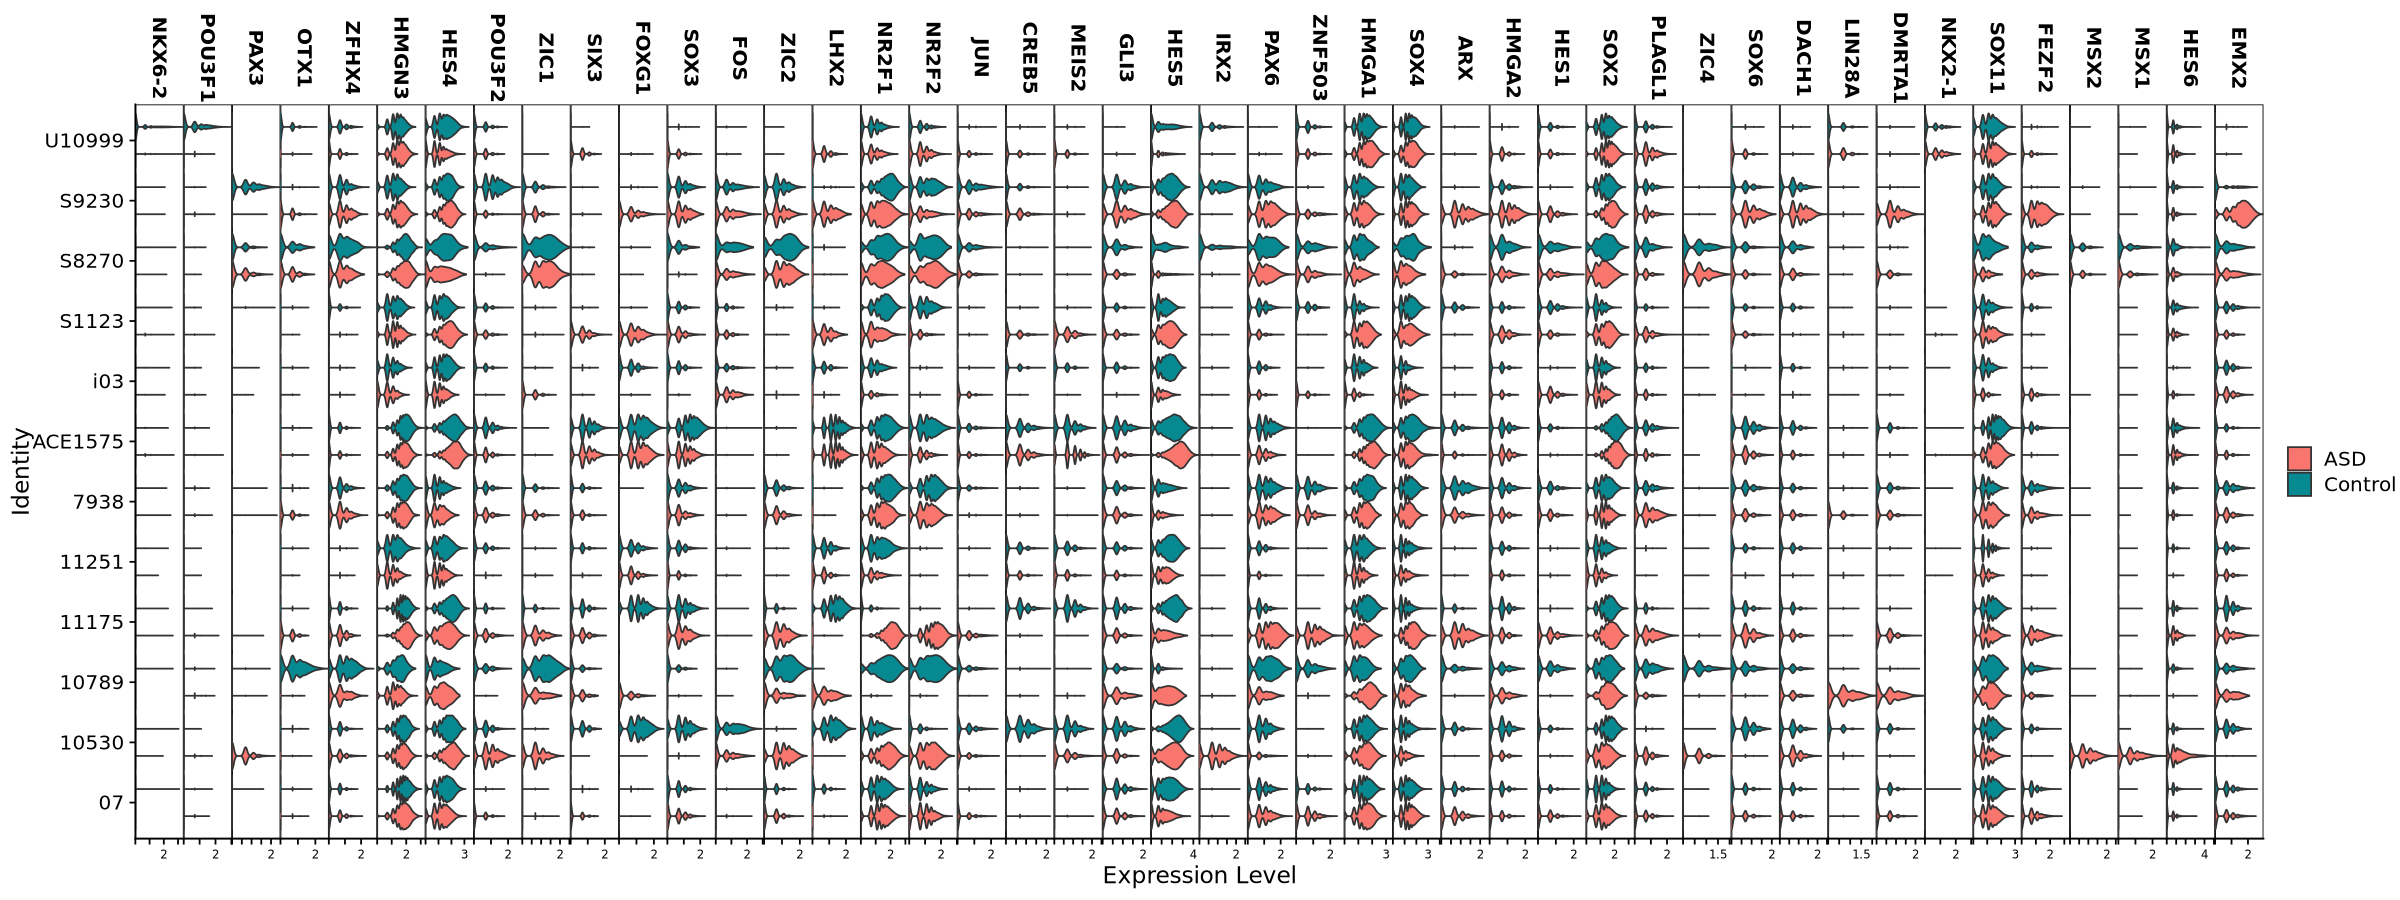

In [82]:
fig(20,7.5)
VlnPlot(rg.obj, features = exp.genelist$Gene, group.by = 'family', split.by = 'ASD.diagnosis', stack = T)

In [28]:
# Get list of genes to plot
exp.genelist <- subset(prob.markers, (dataset == 'DE Jourdon') & (gene.group == 'TFs')) %>% select(Gene, r.AC) %>% arrange(r.AC)
dp.expdata <- Seurat::DotPlot(rg.obj, features = exp.genelist$Gene, group.by = 'library')$data

In [29]:
dp.expdata <- rg.obj@meta.data %>% select(library, family, family.grouping, ASD.diagnosis) %>% unique %>% merge(y = dp.expdata, by.x = 'library', by.y = 'id', all = T)

In [30]:
dp.expdata <- dp.expdata %>% mutate(features.plot = factor(features.plot, levels = exp.genelist$Gene))

In [ ]:
fig(10,10)

# Output file for the expression dot plots (DE TFs)
plot_exp_dot <- glue('{plot_dir}Expression.Dotplot.DE_TFs.pdf')
cairo_pdf(filename = plot_exp_dot, width = 10, height = 10, onefile = T)
(ggplot(dp.expdata, aes(x = ASD.diagnosis, y = features.plot, size = pct.exp, color = avg.exp.scaled)) + 
     geom_point() + 
     scale_color_gradient2(low = 'blue', mid = 'grey', high = 'tomato', midpoint = 0) +
     facet_nested(cols = vars(family.grouping, family))) %>% stylize()

(ggplot(dp.expdata, aes(x = family, y = features.plot, size = pct.exp, color = avg.exp.scaled)) + 
     geom_point() + 
     scale_color_gradient2(low = 'blue', mid = 'grey', high = 'tomato', midpoint = 0) +
     facet_nested(cols = vars(family.grouping, ASD.diagnosis), scales = 'free', space = 'free')) %>% stylize()


(ggplot(dp.expdata, aes(x = family, y = features.plot, size = pct.exp, color = avg.exp.scaled)) + 
     geom_point() + 
     scale_color_gradient2(low = 'blue', mid = 'grey', high = 'tomato', midpoint = 0) +
     facet_nested(cols = vars(ASD.diagnosis, family.grouping), scales = 'free', space = 'free')) %>% stylize()

dev.off()


pdf 
  2

In [ ]:
## Version for Nicola:
# - Plot families separately
# - In each case, sort genes by ASD-Ctrl expression ratio in that family
# - Join plots

split(dp.expdata, apply(dp.expdata[,c('family', 'features.plot')], FUN = paste, MARGIN = 1, collapse = ' - ')) %>%
lapply(function(x){
    x %>% mutate(avg.exp.ratio = ( 
        (1e-6 +subset(x, ASD.diagnosis == 'ASD')$avg.exp ) / (1e-6 +subset(x, ASD.diagnosis != 'ASD')$avg.exp)
    ))}) %>% 
do.call(what = 'rbind') %>% 
group_by(family, ASD.diagnosis) %>% 
arrange(avg.exp.ratio) %>% 
mutate(ratio.rank = rank(avg.exp.ratio, ties.method = 'random')) %>% 
ungroup() %>% 
arrange(ratio.rank, family, ASD.diagnosis) %>%
mutate(y.pos = paste(family, ratio.rank, features.plot, sep = ' - '), 
       y.pos = factor(x.pos, levels = unique(x.pos))) -> dp.expdata

fig(16, 10)
# Output file for the expression dot plot (DE TFs, sorted per family)
plot_exp_dot_sorted <- glue('{plot_dir}Expression.Dotplot.DE_TFs.Sorted_per_family.pdf')
cairo_pdf(filename = plot_exp_dot_sorted, width = 16, height = 10, onefile = T)
(ggplot(dp.expdata, aes(x = ASD.diagnosis, y = y.pos, size = pct.exp, color = avg.exp.scaled)) + 
     geom_point() + 
     scale_color_gradient2(low = 'blue', mid = 'grey', high = 'tomato', midpoint = 0) +
     facet_nested(cols = vars(family.grouping, family), 
                  independent = 'y', scales='free') + 
     scale_x_discrete(position = 'top') +
     scale_y_discrete(name = 'TF', labels = function(x){sapply(x, function(y){
         strsplit(y, split = ' - ', fixed = T)[[1]] %>% rev() %>% head(n = 1)})})
) %>% stylize() + theme(axis.text.x.top = element_text(angle = 90, hjust = 0, vjust = .5))
dev.off()


pdf 
  2

#### Expression ratio ASD-ASD vs Ctrl-Ctrl

In [ ]:
fig(12,10)

(ggplot(submarkers, aes(x = group.name, y = abs(avg_log2FC), color = group.name, fill = group.name)) + 
    geom_violin(color = 'transparent') +
    geom_boxplot(outlier.alpha = 0.1, fill = 'white', width = .25, color = 'black', show.legend = F) +
    scale_fill_manual(values=group.pal) + 
    labs(x = 'Compared samples from Jourdon et al.', 
         y = 'Gene expression ratio\n(|avg. logFC|)', fill = 'Compared samples\nfrom Jourdon et al.') +
    facet_grid(cols=vars(geneset))) %>% stylize(no.legend = F) -> vb1


(ggplot(submarkers, aes(x = geneset, y = abs(avg_log2FC), color = group.name, fill = group.name)) + 
    geom_violin(color = 'transparent') +
    geom_boxplot(outlier.alpha = 0.1, fill = 'white', width = .25, color = 'black', show.legend = F) +
    scale_fill_manual(values=group.pal) + 
    labs(x = 'Sets of DEGs from our in vitro D8', 
         # y = NULL,
         y = 'Gene expression ratio\n(|avg. logFC|)',
         fill = 'Compared samples\nfrom Jourdon et al.') +
    facet_grid(cols=vars(group.name))) %>% stylize() -> vb2

cowplot::plot_grid(vb1, vb2, nrow = 2, ncol = 1, rel_widths = c(1,1.5), align = 'h', axis = 'tb') -> p

# Output file for the combined FC violin plots
plot_fc_violin <- glue('{plot_dir}FCcomparison.Violin.pdf')
cairo_pdf(filename = plot_fc_violin, width = 12, height = 10, onefile = T)
plot(p)
dev.off()

fig(7,6)
(ggplot(subset(submarkers, geneset == 'D8 DE TFs'), aes(x = group.name, y = abs(avg_log2FC), color = group.name, fill = group.name)) + 
    geom_violin(color = 'transparent') +
    geom_boxplot(outlier.alpha = 0.1, fill = 'white', width = .25, color = 'black', show.legend = F) +
    scale_fill_manual(values=group.pal) + 
    labs(x = 'Compared samples from Jourdon et al.', 
         y = 'Gene expression ratio\n(|avg. logFC|)', fill = 'Compared samples\nfrom Jourdon et al.') +
    facet_grid(cols=vars(geneset))) %>% stylize(no.legend = F) -> p

# Output file for the FC violin plot (D8 TF genes only)
plot_fc_violin_d8tf <- glue('{plot_dir}FCcomparison.Violin.D8_TF_genes.pdf')
cairo_pdf(filename = plot_fc_violin_d8tf, width = 7, height = 6, onefile = T)
plot(p)
dev.off()

fig(28,10)

(ggplot(submarkers, aes(x = abs(avg_log2FC), color = group.name, fill = group.name)) + 
    scale_color_manual(values=group.pal) + 
    scale_fill_manual(values=group.pal) + 
    facet_nested(rows=vars(dataset, gene.group), scales = 'free', switch = 'y') +
    scale_x_continuous(expand = expansion(mult = c(0,0))) +
    scale_y_continuous(expand = expansion(mult = c(0,0.05)), labels = scales::label_percent()) +
    labs(x = 'Gene expression ratio\n(|avg. logFC|)', 
         y = 'Fraction of genes', 
         fill = 'Compared samples\nfrom Jourdon et al.', color = 'Compared samples\nfrom Jourdon et al.')
) %>% stylize() + theme(legend.position = 'top') -> h1

for (g1 in unique(submarkers$group.name)){
    for (g2 in unique(submarkers$geneset)){
        h1 <- h1 + geom_histogram(data = subset(submarkers, (group.name == g1) & (geneset == g2)),
                                  aes(y=..count../sum(..count..)), 
                                  fill = 'transparent',
                                  alpha=0.1, bins = 20, linewidth = 1)
    }
}


(ggplot(submarkers, aes(x = abs(avg_log2FC), color = gene.group, fill = gene.group)) + 
    facet_grid(rows=vars(group.name), cols = vars(dataset), scales = 'free', switch = 'y') +
    scale_x_continuous(expand = expansion(mult = c(0,0))) +
    labs(x = 'Gene expression ratio\n(|avg. logFC|)', 
         y = 'Fraction of genes', 
         fill = 'TF or other', color = 'TF or other') +
    scale_y_continuous(expand = expansion(mult = c(0,0.05)), labels = scales::label_percent())
) %>% stylize() + theme(legend.position = 'top') -> h2
for (g1 in unique(submarkers$group.name)){
    for (g2 in unique(submarkers$geneset)){
        h2 <- h2 + geom_histogram(data = subset(submarkers, (group.name == g1) & (geneset == g2)),
                                aes(y=..count../sum(..count..)), 
                                # fill = 'transparent',
                                alpha=0.1, bins = 20, linewidth = 1)
    }
}




(ggplot(submarkers, aes(x = abs(avg_log2FC), color = dataset, fill = dataset)) + 
    scale_color_manual(values=c('Jourdon' = 'black', 'DE Jourdon' = 'blue', 'D8' = 'red')) + 
    scale_fill_manual(values=c('Jourdon' = 'black', 'DE Jourdon' = 'blue', 'D8' = 'red')) + 
    facet_grid(rows=vars(group.name), cols = vars(gene.group), scales = 'free', switch = 'y') +
    scale_x_continuous(expand = expansion(mult = c(0,0))) +
    labs(x = 'Gene expression ratio\n(|avg. logFC|)', 
         y = 'Fraction of genes', 
         fill = 'Sets of DEGs from\nour in vitro D8', color = 'Sets of DEGs from\nour in vitro D8') +
    scale_y_continuous(expand = expansion(mult = c(0,0.05)), labels = scales::label_percent())
) %>% stylize() + theme(legend.position = 'top') -> h3

for (g1 in unique(submarkers$group.name)){
    for (g2 in unique(submarkers$geneset)){
        h3 <- h3 + geom_histogram(data = subset(submarkers, (group.name == g1) & (geneset == g2)),
                                aes(y=..count../sum(..count..)), 
                                # fill = 'transparent',
                                alpha=0.1, bins = 20, linewidth = 1)
    }
}

h1 + h2 + h3 -> p

# Output file for the combined FC histogram plots
plot_fc_hist <- glue('{plot_dir}FCcomparison.HistogramComparisons.pdf')
cairo_pdf(filename = plot_fc_hist, width = 28, height = 10, onefile = T)
plot(p)
dev.off()

pdf 
  2

pdf 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


pdf 
  2